In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import io
from google.colab import drive
import threading
import lightgbm as lgb
import multiprocessing
import time
import tensorflow as tf
drive.mount('/content/drive')
import tensorflow as tf
import os.path
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/device:GPU:0'

In [ ]:
import os.path

train_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_validation.csv")
calendar_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
sellprices2_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
calendar_data2 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")

days_num = 1913

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

start_n = 0

thread_num = 4 #スレッド数
process_num = 8 #プロセス数

print(len(train_data))

current_num = [-1 for jj in range(thread_num + process_num)]  # 実行中のファイル番号(重複処理を防ぐ)

def stap(ST):
        return calendar_data2["snap_" + ST]

def traindata2_making(th_num):
    for ii in range(start_n, len(train_data)):
        if ((ii in current_num) == False): #その行は処理されていない
            current_num[th_num] = ii
            if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
                train_data2a = train_data2a0.copy()
                tra_sir = train_data.iloc[ii]
                for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
                train_data2a.iloc[:,6] = calendar_data.iloc[:,1] #週
                train_data2a.iloc[:,7:11] = calendar_data.iloc[:,3:7] #年, 月, 曜日
                train_data2a.iloc[:,11:15] = calendar_data2.iloc[:,1:5] #イベント情報
                train_data2a.iloc[:,15] = stap(tra_sir[5]) #snap

                sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
                sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
                sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

                train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

                train_data2a["value"] = tra_sir[6:].to_list()

                train_data2a.to_csv(
                    "/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv", index=False)
            current_num[th_num] = -1

thread_list = []
with tf.device('/cpu:0'):
  for i in range(thread_num):
      thread = threading.Thread(target=traindata2_making, args=(i,))
      thread.start()
      thread_list.append(thread)
      print(i)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

with tf.device('/gpu:0'):
  for i2 in range(thread_num, thread_num + process_num):
      mp = threading.Thread(target=traindata2_making, args=(i2,))
      mp.start()
      thread_list.append(thread)
      print(i2)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

while(True):
  print('\r', end='')
  print(current_num, end='')
  sleep_seconds = 2
  time.sleep(sleep_seconds)

for thread in thread_list:
    thread.join()

30490
0
1
2
3


KeyboardInterrupt: ignored

In [ ]:
ii = 1413
if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
  train_data2a = train_data2a0.copy()
  tra_sir = train_data.iloc[ii]
  for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
  train_data2a.iloc[:,6] = calendar_data.iloc[:,1] #週
  train_data2a.iloc[:,7:11] = calendar_data.iloc[:,3:7] #年, 月, 曜日
  train_data2a.iloc[:,11:15] = calendar_data2.iloc[:,1:5] #イベント情報
  train_data2a.iloc[:,15] = stap(tra_sir[5]) #snap

  sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
  sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
  sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

  train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

  train_data2a["value"] = tra_sir[6:].to_list()

  train_data2a.to_csv(
      "/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv", index=False)
else: print("files exist")

files exist


In [ ]:
df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(1413) + ".csv")

In [ ]:
os.remove("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(1413) + ".csv")

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_0.csv")
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu.txt", mode='w') as f:
    f.write(str(1))

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari.csv")
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu.txt") as f:
    ii = int(f.read())
max_ii = 30490
error_flag = False

while True:
  try:
    df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv")
  except:
    print(str(ii)+ "doesn't exist")
    error_flag = True
  else:
    main_data = pd.concat([main_data, df])
    print('\r', end='')
    print(ii, end='')
    if (ii%100 == 0):
      if (error_flag == True): sys.exit(1)
      with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu.txt", mode='w') as f:
        f.write(str(ii))
      main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari.csv", index=False)
  finally:
    ii += 1
    
  

main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_all.csv", index=False)

1400

In [ ]:
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu.txt") as f:
    ii = int(f.read()) + 1
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv")
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari2.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu2.txt", mode='w') as f:
    f.write(str(ii))

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari2.csv")
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu2.txt") as f:
    ii = int(f.read())
max_ii = 30490
error_flag = False

while True:
  try:
    df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv")
  except:
    print(str(ii)+ "doesn't exist")
    error_flag = True
  else:
    main_data = pd.concat([main_data, df])
    print('\r', end='')
    print(ii, end='')
    if (ii%100 == 0):
      if (error_flag == True): sys.exit(1)
      with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu2.txt", mode='w') as f:
        f.write(str(ii))
      main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari2.csv", index=False)
  finally:
    ii += 1
    
  

main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_all.csv", index=False)

22486

In [ ]:
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu2.txt") as f:
    ii = int(f.read()) + 1
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv")
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari3.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu3.txt", mode='w') as f:
    f.write(str(ii))

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari3.csv")
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu3.txt") as f:
    ii = int(f.read())
max_ii = 30490
error_flag = False

while True:
  try:
    df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_" + str(ii) + ".csv")
  except:
    print(str(ii)+ "doesn't exist")
    error_flag = True
  else:
    main_data = pd.concat([main_data, df])
    print('\r', end='')
    print(ii, end='')
    if (ii%100 == 0):
      if (error_flag == True): sys.exit(1)
      with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu3.txt", mode='w') as f:
        f.write(str(ii))
      main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari3.csv", index=False)
  finally:
    ii += 1
    
  

main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari3.csv", index=False)

In [ ]:
mda1 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari.csv")
mda2 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari2.csv")
mda3 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari3.csv")

main_data = pd.concat([mda1, mda2, mda3])
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all.csv", index=False)

In [20]:
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

m1 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all.csv", dtype=size_cols)
m1 = m1.drop_duplicates(subset='id')
m1_id = m1['id'].values.tolist()
m2 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_evaluation.csv")
m2_id = m2['id'].values.tolist()

print(len(m1_id))

for ii in range(len(m1_id)):
  m2_id.remove(m1_id[ii])
  print("\r"+ str(ii), end=" ")

m2_export = pd.DataFrame({'id': m2_id})

m2_export.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_add_row.csv", index=False)



30490


ValueError: ignored

In [ ]:
import os.path

train_data0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_add_row.csv")
train_data1 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_validation.csv")
train_data = pd.merge(train_data0, train_data1, on='id')


calendar_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
sellprices2_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
calendar_data2 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")

days_num = 1941

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

start_n = 0

thread_num = 4 #スレッド数
process_num = 8 #プロセス数

print(len(train_data))

current_num = [-1 for jj in range(thread_num + process_num)]  # 実行中のファイル番号(重複処理を防ぐ)

def stap(ST):
        return calendar_data2["snap_" + ST]

def traindata2_making(th_num):
    for ii in range(len(train_data)):
        if ((ii in current_num) == False): #その行は処理されていない
            current_num[th_num] = ii
            if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_add" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
                train_data2a = train_data2a0.copy()
                tra_sir = train_data.iloc[ii]
                for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
                train_data2a.iloc[:,6] = calendar_data.iloc[:,1] #週
                train_data2a.iloc[:,7:11] = calendar_data.iloc[:,3:7] #年, 月, 曜日
                train_data2a.iloc[:,11:15] = calendar_data2.iloc[:,1:5] #イベント情報
                train_data2a.iloc[:,15] = stap(tra_sir[5]) #snap

                sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
                sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
                sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

                train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

                train_data2a["value"] = tra_sir[6:].to_list()

                train_data2a.to_csv(
                    "/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_add" + str(ii) + ".csv", index=False)
            current_num[th_num] = -1

thread_list = []
with tf.device('/cpu:0'):
  for i in range(thread_num):
      thread = threading.Thread(target=traindata2_making, args=(i,))
      thread.start()
      thread_list.append(thread)
      print(i)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

with tf.device('/gpu:0'):
  for i2 in range(thread_num, thread_num + process_num):
      mp = threading.Thread(target=traindata2_making, args=(i2,))
      mp.start()
      thread_list.append(thread)
      print(i2)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

while(True):
  print('\r', end='')
  print(current_num, end='')
  sleep_seconds = 30
  time.sleep(sleep_seconds)

for thread in thread_list:
    thread.join()

In [ ]:
import os.path

train_data0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_add_row.csv")
train_data1 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_validation.csv")
train_data = pd.merge(train_data0, train_data1, on='id')


calendar_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
sellprices2_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
calendar_data2 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")

days_num = 1913

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

for ii in range(7182):
  if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_add" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
    train_data2a = train_data2a0.copy()
    tra_sir = train_data.iloc[ii]
    for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
    train_data2a.iloc[:,6] = calendar_data.iloc[:,1] #週
    train_data2a.iloc[:,7:11] = calendar_data.iloc[:,3:7] #年, 月, 曜日
    train_data2a.iloc[:,11:15] = calendar_data2.iloc[:,1:5] #イベント情報
    train_data2a.iloc[:,15] = stap(tra_sir[5]) #snap

    sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
    sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
    sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

    train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

    train_data2a["value"] = tra_sir[6:].to_list()

    train_data2a.to_csv(
        "/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_add" + str(ii) + ".csv", index=False)

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_add" + str(0) + ".csv")
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari_add.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu_add.txt", mode='w') as f:
    f.write(str(1))

In [ ]:
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari_add.csv", dtype=size_cols)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu_add.txt") as f:
    ii = int(f.read())
max_ii = 7181
error_flag = False

while True:
  try:
    df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_add" + str(ii) + ".csv", dtype=size_cols)
  except:
    print(str(ii)+ "doesn't exist")
    error_flag = True
  else:
    main_data = pd.concat([main_data, df])
    print('\r', end='')
    print(ii, end='')
    if (ii%100 == 0):
      if (error_flag == True): sys.exit(1)
      with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_syukeityu_add.txt", mode='w') as f:
        f.write(str(ii))
      main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari_add.csv", index=False)
  finally:
    ii += 1
    if (ii > max_ii): break
    
  

main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari_add.csv", index=False)

71817182doesn't exist


In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}
mda1 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all.csv", dtype=size_cols)
mda2 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_kari_add.csv", dtype=size_cols)

main_data = pd.concat([mda1, mda2])
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all2.csv", index=False)

del mda1, mda2, main_data
gc.collect()

1462

train2a_all2.csvが正常であるか調べ, 問題がなければtrain2a_all.csvに名称変更

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all.csv", dtype=size_cols)
mda = mda.drop_duplicates()
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all.csv", index=False)

del mda
gc.collect()


0

d_の形式は扱いづらいので数値に変換

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all.csv", dtype=size_cols)
def d_del(x):
  if ("d_" in x): return x[2:]
  else: return x

mda = mda.drop_duplicates()
mda['d'] = mda['d'].map(d_del)
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all2.csv", index=False)

del mda
gc.collect()

0

sell_priceのNaNを0に変換

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all2.csv", dtype=size_cols)

mda = mda.fillna({'sell_price': '0'})

mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all2.csv", index=False)

del mda
gc.collect()

330

In [ ]:
import gc
mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all2.csv")

x1_data_CA = mda[mda['state_id']=="CA"]
x1_data_TX = mda[mda['state_id']=="TX"]
x1_data_WI = mda[mda['state_id']=="WI"]

x1_data_CA.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x1_data_CA.csv", index=False)
x1_data_TX.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x1_data_TX.csv", index=False)
x1_data_WI.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x1_data_WI.csv", index=False)

del x1_data_CA, x1_data_TX, x1_data_WI
gc.collect()

x2_data_CA_1 = mda[mda['store_id']=="CA_1"]
x2_data_CA_2 = mda[mda['store_id']=="CA_2"]
x2_data_CA_3 = mda[mda['store_id']=="CA_3"]
x2_data_CA_4 = mda[mda['store_id']=="CA_4"]
x2_data_TX_1 = mda[mda['store_id']=="TX_1"]
x2_data_TX_2 = mda[mda['store_id']=="TX_2"]
x2_data_TX_3 = mda[mda['store_id']=="TX_3"]
x2_data_WI_1 = mda[mda['store_id']=="WI_1"]
x2_data_WI_2 = mda[mda['store_id']=="WI_2"]
x2_data_WI_3 = mda[mda['store_id']=="WI_3"]

x2_data_CA_1.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_CA_1.csv", index=False)
x2_data_CA_2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_CA_2.csv", index=False)
x2_data_CA_3.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_CA_3.csv", index=False)
x2_data_CA_4.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_CA_4.csv", index=False)
x2_data_TX_1.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_TX_1.csv", index=False)
x2_data_TX_2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_TX_2.csv", index=False)
x2_data_TX_3.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_TX_3.csv", index=False)
x2_data_WI_1.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_WI_1.csv", index=False)
x2_data_WI_2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_WI_2.csv", index=False)
x2_data_WI_3.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x2_data_WI_3.csv", index=False)

del x2_data_CA_1 ,x2_data_CA_2 ,x2_data_CA_3 ,x2_data_TX_1 ,x2_data_TX_2 ,x2_data_TX_3 ,x2_data_WI_1 ,x2_data_WI_2 ,x2_data_WI_3
gc.collect()

x3_data_FOODS = mda[mda['cat_id']=="FOODS"]
x3_data_HOUSEHOLD = mda[mda['cat_id']=="HOUSEHOLD"]
x3_data_HOBBIES = mda[mda['cat_id']=="HOBBIES"]

x3_data_FOODS.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x3_data_FOODS.csv", index=False)
x3_data_HOUSEHOLD.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x3_data_HOUSEHOLD.csv", index=False)
x3_data_HOBBIES.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x3_data_HOBBIES.csv", index=False)

del x3_data_FOODS ,x3_data_HOUSEHOLD, x3_data_HOBBIES
gc.collect()

x4_data_FOODS_1 = mda[mda['dept_id']=="FOODS_1"]
x4_data_FOODS_2 = mda[mda['dept_id']=="FOODS_2"]
x4_data_FOODS_3 = mda[mda['dept_id']=="FOODS_3"]
x4_data_HOUSEHOLD_1 = mda[mda['dept_id']=="HOUSEHOLD_1"]
x4_data_HOUSEHOLD_2 = mda[mda['dept_id']=="HOUSEHOLD_2"]
x4_data_HOBBIES_1 = mda[mda['dept_id']=="HOBBIES_1"]
x4_data_HOBBIES_2 = mda[mda['dept_id']=="HOBBIES_2"]

x4_data_FOODS_1.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_FOODS_1.csv", index=False)
x4_data_FOODS_2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_FOODS_2.csv", index=False)
x4_data_FOODS_3.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_FOODS_3.csv", index=False)
x4_data_HOUSEHOLD_1.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_HOUSEHOLD_1.csv", index=False)
x4_data_HOUSEHOLD_2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_HOUSEHOLD_2.csv", index=False)
x4_data_HOBBIES_1.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_HOBBIES_1.csv", index=False)
x4_data_HOBBIES_2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/x4_data_HOBBIES_2.csv", index=False)

del x4_data_FOODS_1 ,x4_data_FOODS_2 ,x4_data_FOODS_3, x4_data_HOUSEHOLD_1 ,x4_data_HOUSEHOLD_2 ,x4_data_HOBBIES_1, x4_data_HOBBIES_2
gc.collect()

0

クロスバリデーションで各種データを学習

0でないデータを学習

In [ ]:
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn.txt", mode='w') as f:
    f.write(str(0))

In [ ]:
import pickle
import lightgbm as lgb
import gc
from sklearn.model_selection import KFold

with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn.txt") as f:
    ii_start = int(f.read())

x_list_0 = ["x2_data_CA_1","x2_data_CA_2","x2_data_CA_3","x2_data_CA_4","x2_data_TX_1","x2_data_TX_2","x2_data_TX_3","x2_data_WI_1","x2_data_WI_2","x2_data_WI_3","x3_data_FOODS","x3_data_HOUSEHOLD","x3_data_HOBBIES","x4_data_FOODS_1","x4_data_FOODS_2","x4_data_FOODS_3","x4_data_HOUSEHOLD_1","x4_data_HOUSEHOLD_2","x4_data_HOBBIES_1","x4_data_HOBBIES_2"]
x_list_1 = ["x1_data_CA", "x1_data_TX", "x1_data_WI", "x3_data_FOODS", "x3_data_HOUSEHOLD", "x3_data_HOBBIES"]
x_list = x_list_0 + x_list_1
in_cols = ["wday","month","year","National","snap","price_down","price_up","sell_price"]
cat_list = ["wday","month","year","National","snap","price_down","price_up"]
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

folds_num = 5

for ij in range(ii_start, len(x_list)):
  count = 0
  tt = x_list[ij]
  print(tt + ": train start")

  mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/" + tt + ".csv", dtype=size_cols)
  mda = mda[mda["value"] > 0]

#folds_num個に分割
  kf = KFold(n_splits=folds_num, shuffle=True)

  for train_n, test_n in kf.split(mda):
    if (count == folds_num): break

    train_set = mda.iloc[train_n]
    test_set = mda.iloc[test_n]
    train_input = train_set[in_cols]
    for rr in cat_list: train_input[rr] = train_input[rr].astype("category")
    train_result = train_set["value"]
    test_input = test_set[in_cols]
    for rr in cat_list: test_input[rr] = test_input[rr].astype("category")
    test_result = test_set["value"]

    lgb_train = lgb.Dataset(train_input, train_result)
    lgb_test = lgb.Dataset(test_input, test_result)
    # 学習用パラメータ
    lgbm_params = {
      'objective': 'regression',
      'metric': 'rmse',
      "verbosity": 0,}

    clf = lgb.train(lgbm_params, lgb_train,num_boost_round=5000, early_stopping_rounds=10,  valid_sets=lgb_test, learning_rates = [0.05 for ii in range(5000)])

    print(str(count) + "train end")

    file = '/content/drive/My Drive/google_notebook/M5_traindata2/trained_model_' + tt + '_'+ str(count) +'.pkl'
    pickle.dump(clf, open(file, 'wb'))
    count += 1

    del clf, train_input
    gc.collect()

  del mda
  gc.collect()

  with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn.txt", mode='w') as f:
    f.write(str(ij+1))

x2_data_TX_3: train start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


ストリーミング出力は最後の 5000 行に切り捨てられました。
[194]	valid_0's rmse: 6.31349
[195]	valid_0's rmse: 6.31349
[196]	valid_0's rmse: 6.31342
[197]	valid_0's rmse: 6.31343
[198]	valid_0's rmse: 6.31343
[199]	valid_0's rmse: 6.31346
[200]	valid_0's rmse: 6.31347
[201]	valid_0's rmse: 6.31347
[202]	valid_0's rmse: 6.31348
[203]	valid_0's rmse: 6.31345
[204]	valid_0's rmse: 6.31344
[205]	valid_0's rmse: 6.31344
[206]	valid_0's rmse: 6.31345
[207]	valid_0's rmse: 6.31345
[208]	valid_0's rmse: 6.31344
[209]	valid_0's rmse: 6.31344
[210]	valid_0's rmse: 6.31345
[211]	valid_0's rmse: 6.31345
[212]	valid_0's rmse: 6.31345
[213]	valid_0's rmse: 6.31346
[214]	valid_0's rmse: 6.31347
[215]	valid_0's rmse: 6.31346
[216]	valid_0's rmse: 6.31347
[217]	valid_0's rmse: 6.31347
[218]	valid_0's rmse: 6.31347
[219]	valid_0's rmse: 6.31346
[220]	valid_0's rmse: 6.31346
[221]	valid_0's rmse: 6.31345
[222]	valid_0's rmse: 6.31345
[223]	valid_0's rmse: 6.31345
[224]	valid_0's rmse: 6.31344
[225]	valid_0's rmse: 6.31345
[226]	va

01判別

In [2]:
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn.txt", mode='w') as f:
    f.write(str(0))

In [2]:
import pickle
import lightgbm as lgb
import gc
from sklearn.model_selection import KFold

with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn.txt") as f:
    ii_start = int(f.read())

x_list_0 = ["x2_data_CA_1","x2_data_CA_2","x2_data_CA_3","x2_data_CA_4","x2_data_TX_1","x2_data_TX_2","x2_data_TX_3","x2_data_WI_1","x2_data_WI_2","x2_data_WI_3","x3_data_FOODS","x3_data_HOUSEHOLD","x3_data_HOBBIES","x4_data_FOODS_1","x4_data_FOODS_2","x4_data_FOODS_3","x4_data_HOUSEHOLD_1","x4_data_HOUSEHOLD_2","x4_data_HOBBIES_1","x4_data_HOBBIES_2"]
x_list_1 = ["x1_data_CA", "x1_data_TX", "x1_data_WI", "x3_data_FOODS", "x3_data_HOUSEHOLD", "x3_data_HOBBIES"]
x_list = x_list_0 + x_list_1
in_cols = ["wday","month","year","National","snap","price_down","price_up","sell_price"]
cat_list = ["wday","month","year","National","snap","price_down","price_up"]
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

folds_num = 5

for ij in range(ii_start, len(x_list)):
  count = 0
  tt = x_list[ij]
  print(tt + ": train start")

  mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/" + tt + ".csv", dtype=size_cols)
  mda1 = mda[mda["value"] > 0]
  mda0 = mda[mda["value"] == 0]

  mda0["v2"] = 0
  mda1["v2"] = 1

  mda = pd.concat([mda0, mda1])

#folds_num個に分割
  kf = KFold(n_splits=folds_num, shuffle=True)

  for train_n, test_n in kf.split(mda):
    if (count == folds_num): break

    train_set = mda.iloc[train_n]
    test_set = mda.iloc[test_n]
    train_input = train_set[in_cols]
    for rr in cat_list: train_input[rr] = train_input[rr].astype("category")
    train_result = train_set["value"]
    test_input = test_set[in_cols]
    for rr in cat_list: test_input[rr] = test_input[rr].astype("category")
    test_result = test_set["value"]

    lgb_train = lgb.Dataset(train_input, train_result)
    lgb_test = lgb.Dataset(test_input, test_result)
    # 学習用パラメータ
    lgbm_params = {
      'objective': "binary",
      'metric': "binary_logloss",
      "verbosity": 0,}

    clf = lgb.train(lgbm_params, lgb_train,num_boost_round=5000, early_stopping_rounds=10,  valid_sets=lgb_test, learning_rates = [0.05 for ii in range(5000)])

    print(str(count) + "train end")

    file = '/content/drive/My Drive/google_notebook/M5_traindata2/trained_model_' + tt + '_'+ str(count) +'_v2_01.pkl'
    pickle.dump(clf, open(file, 'wb'))
    count += 1

    del clf, train_input
    gc.collect()

  del mda
  gc.collect()

  with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn.txt", mode='w') as f:
    f.write(str(ij+1))

x1_data_CA: train start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

ストリーミング出力は最後の 5000 行に切り捨てられました。
[79]	valid_0's binary_logloss: 0.516462
[80]	valid_0's binary_logloss: 0.516438
[81]	valid_0's binary_logloss: 0.516384
[82]	valid_0's binary_logloss: 0.516345
[83]	valid_0's binary_logloss: 0.516313
[84]	valid_0's binary_logloss: 0.516264
[85]	valid_0's binary_logloss: 0.516235
[86]	valid_0's binary_logloss: 0.516192
[87]	valid_0's binary_logloss: 0.516156
[88]	valid_0's binary_logloss: 0.516124
[89]	valid_0's binary_logloss: 0.5161
[90]	valid_0's binary_logloss: 0.516046
[91]	valid_0's binary_logloss: 0.516024
[92]	valid_0's binary_logloss: 0.516002
[93]	valid_0's binary_logloss: 0.515971
[94]	valid_0's binary_logloss: 0.515944
[95]	valid_0's binary_logloss: 0.515904
[96]	valid_0's binary_logloss: 0.515876
[97]	valid_0's binary_logloss: 0.515843
[98]	valid_0's binary_logloss: 0.515826
[99]	valid_0's binary_logloss: 0.515784
[100]	valid_0's binary_logloss: 0.51575
[101]	valid_0's binary_logloss: 0.515726
[102]	valid_0's binary_logloss: 0.515682
[103]	va

テストデータを作成

In [ ]:
import os.path

days_start = 1914
days_end = 1941

train_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_evaluation.csv")
calendar_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
calendar_data = calendar_data_0[days_start-1:].reset_index(drop=True)
sellprices2_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
sellprices2_data = sellprices2_data_0[days_start-1:].reset_index(drop=True)
calendar_data2_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")
calendar_data2 = calendar_data2_0[days_start-1:].reset_index(drop=True)

days_num = days_end - days_start + 1

days_list = ["d_" + str(ii) for ii in range(days_start, days_end + 1)]

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

start_n = 0

thread_num = 4 #スレッド数
process_num = 8 #プロセス数

print(len(train_data))

current_num = [-1 for jj in range(thread_num + process_num)]  # 実行中のファイル番号(重複処理を防ぐ)

def stap(ST):
        return calendar_data2["snap_" + ST]

def traindata2_making(th_num):
    for ii in range(start_n, len(train_data)):
        if ((ii in current_num) == False): #その行は処理されていない
            current_num[th_num] = ii
            if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
                train_data2a = train_data2a0.copy()
                tra_sir = train_data.iloc[ii]
                for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
                train_data2a.iloc[:,6] = calendar_data.iloc[: ,1] #週
                train_data2a.iloc[:,7:11] = calendar_data.iloc[: ,3:7] #年, 月, 曜日
                train_data2a.iloc[:,11:15] = calendar_data2.iloc[: ,1:5] #イベント情報
                tds_kari = stap(tra_sir[5]) #snap
                train_data2a.iloc[:,15] = tds_kari

                sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
                sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
                sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

                train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

                train_data2a["value"] = tra_sir[1919:].to_list()
                

                train_data2a.to_csv(
                    "/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(ii) + ".csv", index=False)
            current_num[th_num] = -1

thread_list = []
with tf.device('/cpu:0'):
  for i in range(thread_num):
      thread = threading.Thread(target=traindata2_making, args=(i,))
      thread.start()
      thread_list.append(thread)
      print(i)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

with tf.device('/gpu:0'):
  for i2 in range(thread_num, thread_num + process_num):
      mp = threading.Thread(target=traindata2_making, args=(i2,))
      mp.start()
      thread_list.append(thread)
      print(i2)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

while(True):
  print('\r', end='')
  print(current_num, end='')
  sleep_seconds = 10
  time.sleep(sleep_seconds)

for thread in thread_list:
    thread.join()

30490
0
1
2
3
4
5
6
7
8
9
10
11
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [ ]:
import os
for ii in [2453, 2464, 2470, 2475, 2482, 2493]:
  os.remove("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(ii) + ".csv")

In [ ]:
import os.path

days_start = 1914
days_end = 1941

train_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_evaluation.csv")
calendar_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
calendar_data = calendar_data_0[days_start-1:].reset_index(drop=True)
sellprices2_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
sellprices2_data = sellprices2_data_0[days_start-1:].reset_index(drop=True)
calendar_data2_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")
calendar_data2 = calendar_data2_0[days_start-1:].reset_index(drop=True)

days_num = days_end - days_start + 1

days_list = ["d_" + str(ii) for ii in range(days_start, days_end + 1)]

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

def stap(ST):
    return calendar_data2["snap_" + ST]

for ii in range(30490):
  print("\r"+str(ii), end = " ")
  if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
    train_data2a = train_data2a0.copy()
    tra_sir = train_data.iloc[ii]
    for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
    train_data2a.iloc[:,6] = calendar_data.iloc[: ,1] #週
    train_data2a.iloc[:,7:11] = calendar_data.iloc[: ,3:7] #年, 月, 曜日
    train_data2a.iloc[:,11:15] = calendar_data2.iloc[: ,1:5] #イベント情報
    tds_kari = stap(tra_sir[5]) #snap
    train_data2a.iloc[:,15] = tds_kari

    sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
    sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
    sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

    train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

    train_data2a["value"] = tra_sir[1919:].to_list()

    train_data2a.to_csv(
        "/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(ii) + ".csv", index=False)

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(0) + ".csv")
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_kari.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_syukeityu.txt", mode='w') as f:
    f.write(str(1))

In [ ]:
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_kari.csv", dtype=size_cols)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_syukeityu.txt") as f:
    ii = int(f.read())
max_ii = 30489
error_flag = False

while True:
  try:
    df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_" + str(ii) + ".csv", dtype=size_cols)
  except:
    print(str(ii)+ "doesn't exist")
    error_flag = True
  else:
    main_data = pd.concat([main_data, df])
    print('\r', end='')
    print(ii, end='')
    if (ii%100 == 0):
      if (error_flag == True): sys.exit(1)
      with open("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_syukeityu.txt", mode='w') as f:
        f.write(str(ii))
      main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_kari.csv", index=False)
  finally:
    ii += 1
    if (ii > max_ii): break
    
  

main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_kari.csv", index=False)

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test_data2a/test2a_kari.csv", dtype=size_cols)
mda = mda.drop_duplicates()
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test2a_all.csv", index=False)

del mda
gc.collect()

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test2a_all.csv", dtype=size_cols)
def d_del(x):
  if ("d_" in x): return x[2:]
  else: return x

mda = mda.drop_duplicates()
mda['d'] = mda['d'].map(d_del)
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test2a_all.csv", index=False)

del mda
gc.collect()

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test2a_all.csv", dtype=size_cols)

mda = mda.fillna({'sell_price': '0'})

mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/test2a_all.csv", index=False)

del mda
gc.collect()

提出用データの入力データを作成

In [ ]:
import os.path

days_start = 1942
days_end = 1969

train_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_validation.csv")
train_data = train_data_0[days_start-1:].reset_index(drop=True)
calendar_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
calendar_data = calendar_data_0[days_start-1:].reset_index(drop=True)
sellprices2_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
sellprices2_data = sellprices2_data_0[days_start-1:].reset_index(drop=True)
calendar_data2_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")
calendar_data2 = calendar_data2_0[days_start-1:].reset_index(drop=True)

days_num = days_end - days_start + 1

days_list = ["d_" + str(ii) for ii in range(days_start, days_end + 1)]

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

start_n = 0

thread_num = 4 #スレッド数
process_num = 8 #プロセス数

print(len(train_data))

current_num = [-1 for jj in range(thread_num + process_num)]  # 実行中のファイル番号(重複処理を防ぐ)

def stap(ST):
        return calendar_data2["snap_" + ST]

def traindata2_making(th_num):
    for ii in range(start_n, len(train_data)):
        if ((ii in current_num) == False): #その行は処理されていない
            current_num[th_num] = ii
            if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
                train_data2a = train_data2a0.copy()
                tra_sir = train_data.iloc[ii]
                for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
                train_data2a.iloc[:,6] = calendar_data.iloc[: ,1] #週
                train_data2a.iloc[:,7:11] = calendar_data.iloc[: ,3:7] #年, 月, 曜日
                train_data2a.iloc[:,11:15] = calendar_data2.iloc[: ,1:5] #イベント情報
                tds_kari = stap(tra_sir[5]) #snap
                train_data2a.iloc[:,15] = tds_kari

                sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
                sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
                sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

                train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

                train_data2a.to_csv(
                    "/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(ii) + ".csv", index=False)
            current_num[th_num] = -1

thread_list = []
with tf.device('/cpu:0'):
  for i in range(thread_num):
      thread = threading.Thread(target=traindata2_making, args=(i,))
      thread.start()
      thread_list.append(thread)
      print(i)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

with tf.device('/gpu:0'):
  for i2 in range(thread_num, thread_num + process_num):
      mp = threading.Thread(target=traindata2_making, args=(i2,))
      mp.start()
      thread_list.append(thread)
      print(i2)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

while(True):
  print('\r', end='')
  print(current_num, end='')
  sleep_seconds = 10
  time.sleep(sleep_seconds)

for thread in thread_list:
    thread.join()

30490
0
1
2
3
4
5
6
7
8
9
10
11
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

KeyboardInterrupt: ignored

In [ ]:
import os.path

days_start = 1942
days_end = 1969

train_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sales_train_validation.csv")
calendar_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar.csv")
calendar_data = calendar_data_0[days_start-1:].reset_index(drop=True)
sellprices2_data_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sell_prices2.csv")
sellprices2_data = sellprices2_data_0[days_start-1:].reset_index(drop=True)
calendar_data2_0 = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/calendar2.csv")
calendar_data2 = calendar_data2_0[days_start-1:].reset_index(drop=True)

days_num = days_end - days_start + 1

days_list = ["d_" + str(ii) for ii in range(days_start, days_end + 1)]

cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "wm_yr_wk", "wday", "month", "year", "d",
        "Religious", "National", "Cultural", "Sporting", "snap"] #"price", "price_down", "price_up", "value"は後程追加
train_data2a0 = pd.DataFrame(index=[ij for ij in range(days_num)], columns=cols)

def stap(ST):
    return calendar_data2["snap_" + ST]

for ii in range(30490):
  print("\r"+str(ii), end = " ")
  if (os.path.isfile("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(ii) + ".csv") == False):  # ファイルがまだ作成されていない
    train_data2a = train_data2a0.copy()
    tra_sir = train_data.iloc[ii]
    for jj in range(days_num):train_data2a.iloc[jj,0:6] = tra_sir[0:6]
    train_data2a.iloc[:,6] = calendar_data.iloc[: ,1] #週
    train_data2a.iloc[:,7:11] = calendar_data.iloc[: ,3:7] #年, 月, 曜日
    train_data2a.iloc[:,11:15] = calendar_data2.iloc[: ,1:5] #イベント情報
    tds_kari = stap(tra_sir[5]) #snap
    train_data2a.iloc[:,15] = tds_kari

    sap_mindata = sellprices2_data[sellprices2_data.item_id == tra_sir[1]]  # sellpricesの中から必要なデータを抽出
    sap_mindata = sap_mindata[sap_mindata.store_id == tra_sir[4]]
    sap_mindata = sap_mindata.drop(["store_id", "item_id"], axis=1)

    train_data2a = pd.merge(train_data2a, sap_mindata, on='wm_yr_wk', how='left') #価格とその変化

    train_data2a.to_csv(
        "/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(ii) + ".csv", index=False)

30489 

In [ ]:
import os
for ii in [2453, 2464, 2470, 2475, 2482, 2493]:
  os.remove("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(ii) + ".csv")

In [ ]:
main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(0) + ".csv")
main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_kari.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_syukeityu.txt", mode='w') as f:
    f.write(str(1))

In [ ]:
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

main_data = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_kari.csv", dtype=size_cols)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_syukeityu.txt") as f:
    ii = int(f.read())
max_ii = 30489
error_flag = False

while True:
  try:
    df = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_" + str(ii) + ".csv", dtype=size_cols)
  except:
    print(str(ii)+ "doesn't exist")
    error_flag = True
  else:
    main_data = pd.concat([main_data, df])
    print('\r', end='')
    print(ii, end='')
    if (ii%100 == 0):
      if (error_flag == True): sys.exit(1)
      with open("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_syukeityu.txt", mode='w') as f:
        f.write(str(ii))
      main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_kari.csv", index=False)
  finally:
    ii += 1
    if (ii > max_ii): break
    
  

main_data.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_kari.csv", index=False)

30489

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export_data2a/export2a_kari.csv", dtype=size_cols)
mda = mda.drop_duplicates()
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_all.csv", index=False)

del mda
gc.collect()

217

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_all.csv", dtype=size_cols)
def d_del(x):
  if ("d_" in x): return x[2:]
  else: return x

mda = mda.drop_duplicates()
mda['d'] = mda['d'].map(d_del)
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_all.csv", index=False)

del mda
gc.collect()

0

In [ ]:
import gc

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_all.csv", dtype=size_cols)

mda = mda.fillna({'sell_price': '0'})

mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_all.csv", index=False)

del mda
gc.collect()

0

学習結果を基に出力

In [ ]:
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

trn = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_all2.csv", dtype=size_cols)
trn2 = trn[trn["month"] >= 5]
trn2 = trn2[trn2["month"] <= 6]

trn2.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month.csv", index=False)

In [4]:
mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month.csv")

mda["x1"] = None
mda["x2"] = None
mda["x3"] = None
mda["x4"] = None
mda["x1_01"] = None
mda["x2_01"] = None
mda["x3_01"] = None
mda["x4_01"] = None
mda["final"] = mda["value"]

mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_1st.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/2a_learn_1st.txt", mode='w') as f:
    f.write(str(0))

In [5]:
mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_all.csv")

mda["x1"] = None
mda["x2"] = None
mda["x3"] = None
mda["x4"] = None
mda["final0"] = None
mda["x1_01"] = None
mda["x2_01"] = None
mda["x3_01"] = None
mda["x4_01"] = None
mda["xall_01"] = None
mda["final"] = None

mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_1st.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/2a_learn_1st.txt", mode='w') as f:
    f.write(str(0))

In [2]:
import pickle

with open("/content/drive/My Drive/google_notebook/M5_traindata2/train_data2a/train2a_m_learn2.txt") as f:
    ii_start = int(f.read())

x1_list = ["x1_data_CA", "x1_data_TX", "x1_data_WI"]
x2_list = ["x2_data_CA_1","x2_data_CA_2","x2_data_CA_3","x2_data_CA_4","x2_data_TX_1","x2_data_TX_2","x2_data_TX_3","x2_data_WI_1","x2_data_WI_2","x2_data_WI_3"]
x3_list = ["x3_data_FOODS","x3_data_HOUSEHOLD","x3_data_HOBBIES"]
x4_list = ["x4_data_FOODS_1","x4_data_FOODS_2","x4_data_FOODS_3","x4_data_HOUSEHOLD_1","x4_data_HOUSEHOLD_2","x4_data_HOBBIES_1","x4_data_HOBBIES_2"]
in_cols = ["wday","month","year","National","snap","price_down","price_up","sell_price"]
cat_list = ["wday","month","year","National","snap","price_down","price_up"]
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

# 学習用パラメータ
lgbm_params = {
  'objective': 'regression',
  'metric': 'rmse',
  "verbosity": 0,}

def clf_cal(df, typ, ii):
  
  file = '/content/drive/My Drive/google_notebook/M5_traindata2/trained_model_' + typ + '_'+ str(ii) +'.pkl'
  clf = pickle.load(open(file, 'rb'))
  result = clf.predict(df)
  return result

def combine_1st_cal(df, typ):
  df2 = df[in_cols]
  nda = clf_cal(df2, typ, 0)
  for ii in range(1,5):
    nda += clf_cal(df2, typ, ii)
  nda = nda / 5
  return nda

def x1_cal(df):
  df_CA = df[df["state_id"] == "CA"]
  df_TX = df[df["state_id"] == "TX"]
  df_WI = df[df["state_id"] == "WI"]
  df_CA["x1"] = pd.Series(data=combine_1st_cal(df_CA, x1_list[0]), index=df_CA.index.values)
  df_TX["x1"] = pd.Series(data=combine_1st_cal(df_TX, x1_list[1]), index=df_TX.index.values)
  df_WI["x1"] = pd.Series(data=combine_1st_cal(df_WI, x1_list[2]), index=df_WI.index.values)
  df_f = pd.concat([df_CA, df_TX, df_WI])
  df_f = df_f.sort_index()
  return df_f

def x2_cal(df):
  df_CA_1 = df[df["store_id"] == "CA_1"]
  df_CA_2 = df[df["store_id"] == "CA_2"]
  df_CA_3 = df[df["store_id"] == "CA_3"]
  df_CA_4 = df[df["store_id"] == "CA_4"]
  df_TX_1 = df[df["store_id"] == "TX_1"]
  df_TX_2 = df[df["store_id"] == "TX_2"]
  df_TX_3 = df[df["store_id"] == "TX_3"]
  df_WI_1 = df[df["store_id"] == "WI_1"]
  df_WI_2 = df[df["store_id"] == "WI_2"]
  df_WI_3 = df[df["store_id"] == "WI_3"]
  df_CA_1["x2"] = pd.Series(data=combine_1st_cal(df_CA_1, x2_list[0]), index=df_CA_1.index.values)
  df_CA_2["x2"] = pd.Series(data=combine_1st_cal(df_CA_2, x2_list[1]), index=df_CA_2.index.values)
  df_CA_3["x2"] = pd.Series(data=combine_1st_cal(df_CA_3, x2_list[2]), index=df_CA_3.index.values)
  df_CA_4["x2"] = pd.Series(data=combine_1st_cal(df_CA_4, x2_list[3]), index=df_CA_4.index.values)
  df_TX_1["x2"] = pd.Series(data=combine_1st_cal(df_TX_1, x2_list[4]), index=df_TX_1.index.values)
  df_TX_2["x2"] = pd.Series(data=combine_1st_cal(df_TX_2, x2_list[5]), index=df_TX_2.index.values)
  df_TX_3["x2"] = pd.Series(data=combine_1st_cal(df_TX_3, x2_list[6]), index=df_TX_3.index.values)
  df_WI_1["x2"] = pd.Series(data=combine_1st_cal(df_WI_1, x2_list[7]), index=df_WI_1.index.values)
  df_WI_2["x2"] = pd.Series(data=combine_1st_cal(df_WI_2, x2_list[8]), index=df_WI_2.index.values)
  df_WI_3["x2"] = pd.Series(data=combine_1st_cal(df_WI_3, x2_list[9]), index=df_WI_3.index.values)
  df_f = pd.concat([df_CA_1, df_CA_2, df_CA_3, df_CA_4, df_TX_1, df_TX_2, df_TX_3, df_WI_1, df_WI_2, df_WI_3])
  df_f = df_f.sort_index()
  return df_f

def x3_cal(df):
  df_FOODS = df[df["cat_id"] == "FOODS"]
  df_HOUSEHOLD = df[df["cat_id"] == "HOUSEHOLD"]
  df_HOBBIES = df[df["cat_id"] == "HOBBIES"]
  df_FOODS["x3"] = pd.Series(data=combine_1st_cal(df_FOODS, x3_list[0]), index=df_FOODS.index.values)
  df_HOUSEHOLD["x3"] = pd.Series(data=combine_1st_cal(df_HOUSEHOLD, x3_list[1]), index=df_HOUSEHOLD.index.values)
  df_HOBBIES["x3"] = pd.Series(data=combine_1st_cal(df_HOBBIES, x3_list[2]), index=df_HOBBIES.index.values)
  df_f = pd.concat([df_FOODS, df_HOUSEHOLD, df_HOBBIES])
  df_f = df_f.sort_index()
  return df_f

def x4_cal(df):
  df_FOODS_1 = df[df["dept_id"] == "FOODS_1"]
  df_FOODS_2 = df[df["dept_id"] == "FOODS_2"]
  df_FOODS_3 = df[df["dept_id"] == "FOODS_3"]
  df_HOUSEHOLD_1 = df[df["dept_id"] == "HOUSEHOLD_1"]
  df_HOUSEHOLD_2 = df[df["dept_id"] == "HOUSEHOLD_2"]
  df_HOBBIES_1 = df[df["dept_id"] == "HOBBIES_1"]
  df_HOBBIES_2 = df[df["dept_id"] == "HOBBIES_2"]
  df_FOODS_1["x4"] = pd.Series(data=combine_1st_cal(df_FOODS_1, x4_list[0]), index=df_FOODS_1.index.values)
  df_FOODS_2["x4"] = pd.Series(data=combine_1st_cal(df_FOODS_2, x4_list[1]), index=df_FOODS_2.index.values)
  df_FOODS_3["x4"] = pd.Series(data=combine_1st_cal(df_FOODS_3, x4_list[2]), index=df_FOODS_3.index.values)
  df_HOUSEHOLD_1["x4"] = pd.Series(data=combine_1st_cal(df_HOUSEHOLD_1, x4_list[3]), index=df_HOUSEHOLD_1.index.values)
  df_HOUSEHOLD_2["x4"] = pd.Series(data=combine_1st_cal(df_HOUSEHOLD_2, x4_list[4]), index=df_HOUSEHOLD_2.index.values)
  df_HOBBIES_1["x4"] = pd.Series(data=combine_1st_cal(df_HOBBIES_1, x4_list[5]), index=df_HOBBIES_1.index.values)
  df_HOBBIES_2["x4"] = pd.Series(data=combine_1st_cal(df_HOBBIES_2, x4_list[6]), index=df_HOBBIES_2.index.values)
  df_f = pd.concat([df_FOODS_1, df_FOODS_2, df_FOODS_3, df_HOUSEHOLD_1, df_HOUSEHOLD_2, df_HOBBIES_1, df_HOBBIES_2])
  df_f = df_f.sort_index()
  return df_f

def clf_cal_01(df,typ, ii):
  file = '/content/drive/My Drive/google_notebook/M5_traindata2/trained_model_' + typ + '_'+ str(ii) +'_v2_01.pkl'
  clf = pickle.load(open(file, 'rb'))
  result = clf.predict(df)
  return result

def combine_1st_cal_01(df, typ):
  df2 = df[in_cols]
  nda = clf_cal_01(df2, typ, 0)
  for ii in range(1,5):
    nda += clf_cal_01(df2, typ, ii)
  return nda

def x1_cal_01(df):
  df_CA = df[df["state_id"] == "CA"]
  df_TX = df[df["state_id"] == "TX"]
  df_WI = df[df["state_id"] == "WI"]
  df_CA["x1_01"] = pd.Series(data=combine_1st_cal_01(df_CA, x1_list[0]), index=df_CA.index.values)
  df_TX["x1_01"] = pd.Series(data=combine_1st_cal_01(df_TX, x1_list[1]), index=df_TX.index.values)
  df_WI["x1_01"] = pd.Series(data=combine_1st_cal_01(df_WI, x1_list[2]), index=df_WI.index.values)
  df_f = pd.concat([df_CA, df_TX, df_WI])
  df_f = df_f.sort_index()
  return df_f

def x2_cal_01(df):
  df_CA_1 = df[df["store_id"] == "CA_1"]
  df_CA_2 = df[df["store_id"] == "CA_2"]
  df_CA_3 = df[df["store_id"] == "CA_3"]
  df_CA_4 = df[df["store_id"] == "CA_4"]
  df_TX_1 = df[df["store_id"] == "TX_1"]
  df_TX_2 = df[df["store_id"] == "TX_2"]
  df_TX_3 = df[df["store_id"] == "TX_3"]
  df_WI_1 = df[df["store_id"] == "WI_1"]
  df_WI_2 = df[df["store_id"] == "WI_2"]
  df_WI_3 = df[df["store_id"] == "WI_3"]
  df_CA_1["x2_01"] = pd.Series(data=combine_1st_cal_01(df_CA_1, x2_list[0]), index=df_CA_1.index.values)
  df_CA_2["x2_01"] = pd.Series(data=combine_1st_cal_01(df_CA_2, x2_list[1]), index=df_CA_2.index.values)
  df_CA_3["x2_01"] = pd.Series(data=combine_1st_cal_01(df_CA_3, x2_list[2]), index=df_CA_3.index.values)
  df_CA_4["x2_01"] = pd.Series(data=combine_1st_cal_01(df_CA_4, x2_list[3]), index=df_CA_4.index.values)
  df_TX_1["x2_01"] = pd.Series(data=combine_1st_cal_01(df_TX_1, x2_list[4]), index=df_TX_1.index.values)
  df_TX_2["x2_01"] = pd.Series(data=combine_1st_cal_01(df_TX_2, x2_list[5]), index=df_TX_2.index.values)
  df_TX_3["x2_01"] = pd.Series(data=combine_1st_cal_01(df_TX_3, x2_list[6]), index=df_TX_3.index.values)
  df_WI_1["x2_01"] = pd.Series(data=combine_1st_cal_01(df_WI_1, x2_list[7]), index=df_WI_1.index.values)
  df_WI_2["x2_01"] = pd.Series(data=combine_1st_cal_01(df_WI_2, x2_list[8]), index=df_WI_2.index.values)
  df_WI_3["x2_01"] = pd.Series(data=combine_1st_cal_01(df_WI_3, x2_list[9]), index=df_WI_3.index.values)
  df_f = pd.concat([df_CA_1, df_CA_2, df_CA_3, df_CA_4, df_TX_1, df_TX_2, df_TX_3, df_WI_1, df_WI_2, df_WI_3])
  df_f = df_f.sort_index()
  return df_f

def x3_cal_01(df):
  df_FOODS = df[df["cat_id"] == "FOODS"]
  df_HOUSEHOLD = df[df["cat_id"] == "HOUSEHOLD"]
  df_HOBBIES = df[df["cat_id"] == "HOBBIES"]
  df_FOODS["x3_01"] = pd.Series(data=combine_1st_cal_01(df_FOODS, x3_list[0]), index=df_FOODS.index.values)
  df_HOUSEHOLD["x3_01"] = pd.Series(data=combine_1st_cal_01(df_HOUSEHOLD, x3_list[1]), index=df_HOUSEHOLD.index.values)
  df_HOBBIES["x3_01"] = pd.Series(data=combine_1st_cal_01(df_HOBBIES, x3_list[2]), index=df_HOBBIES.index.values)
  df_f = pd.concat([df_FOODS, df_HOUSEHOLD, df_HOBBIES])
  df_f = df_f.sort_index()
  return df_f

def x4_cal_01(df):
  df_FOODS_1 = df[df["dept_id"] == "FOODS_1"]
  df_FOODS_2 = df[df["dept_id"] == "FOODS_2"]
  df_FOODS_3 = df[df["dept_id"] == "FOODS_3"]
  df_HOUSEHOLD_1 = df[df["dept_id"] == "HOUSEHOLD_1"]
  df_HOUSEHOLD_2 = df[df["dept_id"] == "HOUSEHOLD_2"]
  df_HOBBIES_1 = df[df["dept_id"] == "HOBBIES_1"]
  df_HOBBIES_2 = df[df["dept_id"] == "HOBBIES_2"]
  df_FOODS_1["x4_01"] = pd.Series(data=combine_1st_cal_01(df_FOODS_1, x4_list[0]), index=df_FOODS_1.index.values)
  df_FOODS_2["x4_01"] = pd.Series(data=combine_1st_cal_01(df_FOODS_2, x4_list[1]), index=df_FOODS_2.index.values)
  df_FOODS_3["x4_01"] = pd.Series(data=combine_1st_cal_01(df_FOODS_3, x4_list[2]), index=df_FOODS_3.index.values)
  df_HOUSEHOLD_1["x4_01"] = pd.Series(data=combine_1st_cal_01(df_HOUSEHOLD_1, x4_list[3]), index=df_HOUSEHOLD_1.index.values)
  df_HOUSEHOLD_2["x4_01"] = pd.Series(data=combine_1st_cal_01(df_HOUSEHOLD_2, x4_list[4]), index=df_HOUSEHOLD_2.index.values)
  df_HOBBIES_1["x4_01"] = pd.Series(data=combine_1st_cal_01(df_HOBBIES_1, x4_list[5]), index=df_HOBBIES_1.index.values)
  df_HOBBIES_2["x4_01"] = pd.Series(data=combine_1st_cal_01(df_HOBBIES_2, x4_list[6]), index=df_HOBBIES_2.index.values)
  df_f = pd.concat([df_FOODS_1, df_FOODS_2, df_FOODS_3, df_HOUSEHOLD_1, df_HOUSEHOLD_2, df_HOBBIES_1, df_HOBBIES_2])
  df_f = df_f.sort_index()
  return df_f

def first_cal(f_name):
  f_name_a = f_name + ".csv"
  mda = pd.read_csv(f_name_a, dtype=size_cols)
  for rr in cat_list: mda[rr] = mda[rr].astype("category")
  mda = x1_cal(mda)
  mda = x2_cal(mda)
  mda = x3_cal(mda)
  mda = x4_cal(mda)
  mda = x1_cal_01(mda)
  mda = x2_cal_01(mda)
  mda = x3_cal_01(mda)
  mda = x4_cal_01(mda)
  mda.to_csv(f_name + "2.csv", index=False)



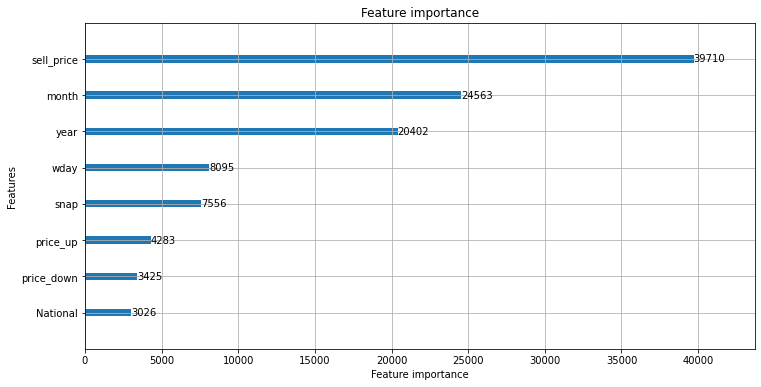

In [17]:

file = '/content/drive/My Drive/google_notebook/M5_traindata2/trained_model_' + "x1_data_CA" + '_'+ str(0) +'_v2_01.pkl'
clf = pickle.load(open(file, 'rb'))

lgb.plot_importance(clf, figsize=(12, 6))

In [3]:
import lightgbm as lgb

first_cal("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_1st")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [4]:
first_cal("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_1st")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [8]:
mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_1st2.csv", dtype=size_cols)

mda.head(15)

,id,item_id,dept_id,cat_id,store_id,state_id,wm_yr_wk,wday,month,year,d,Religious,National,Cultural,Sporting,snap,sell_price,price_down,price_up,value,x1,x2,x3,x4,x1_01,x2_01,x3_01,x4_01,final
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11114,2,5,-37,93,0,0,0,0,2,0.0,NaN,NaN,0,4.409323,14.815737,2.919433,3.102009,0.923256,1.032177e-07,0.757265,0.902871,0
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11114,3,5,-37,94,0,0,0,0,2,0.0,NaN,NaN,0,4.112531,11.727857,2.858967,3.020886,0.864798,2.113831e-07,0.666260,0.798276,0
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11114,4,5,-37,95,0,0,1,0,2,0.0,NaN,NaN,0,3.958525,9.986060,2.839515,2.996057,0.846576,1.195806e-07,0.660570,0.778942,0
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11114,5,5,-37,96,0,0,1,0,2,0.0,NaN,NaN,0,3.879620,9.313118,2.818817,2.978455,0.826927,1.980827e-07,0.660890,0.774370,0
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11114,6,5,-37,97,0,0,2,0,2,0.0,NaN,NaN,0,3.894884,9.641605,2.836732,2.997310,0.825241,1.751291e-07,0.671404,0.789724,0
5,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11114,7,5,-37,98,0,0,1,0,2,0.0,NaN,NaN,0,4.108098,9.878026,2.955879,3.157203,0.866711,1.877875e-07,0.720893,0.852556,0
6,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11115,1,5,-37,99,0,0,1,0,2,0.0,NaN,NaN,0,4.340958,12.543945,3.044811,3.230135,0.923741,8.963548e-08,0.801547,0.961439,0
7,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11115,2,5,-37,100,0,0,2,0,2,0.0,NaN,NaN,0,4.409323,14.815737,2.919433,3.102009,0.923256,1.032177e-07,0.757265,0.902871,0
8,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11115,3,5,-37,101,0,0,0,0,2,0.0,NaN,NaN,0,4.112531,11.727857,2.858967,3.020886,0.864798,2.113831e-07,0.666260,0.798276,0
9,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,11115,4,5,-37,102,0,0,0,0,2,0.0,NaN,NaN,0,3.958525,9.986060,2.839515,2.996057,0.846576,1.195806e-07,0.660570,0.778942,0


In [19]:
import pickle
import lightgbm as lgb
import gc
from sklearn.model_selection import KFold

in_cols = ["x1","x2","x3","x4"]
in_cols2 = ["x1_01","x2_01","x3_01","x4_01"]

size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}

folds_num = 5

count = 0


mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_1st2.csv", dtype=size_cols)
mda0 = mda[mda["value"] == 0]
mda1 = mda[mda["value"] > 0]

mda0["v2"] = 0
mda1["v2"] = 1

mdax = pd.concat([mda0, mda1])

#folds_num個に分割
kf = KFold(n_splits=folds_num, shuffle=True)
kf2 = KFold(n_splits=folds_num, shuffle=True)

for train_n, test_n in kf.split(mda1):
  if (count == folds_num): break

  train_set = mda1.iloc[train_n]
  test_set = mda1.iloc[test_n]

  train_input = train_set[in_cols]
  train_result = train_set["value"]

  test_input = test_set[in_cols]
  test_result = test_set["value"]

  lgb_train = lgb.Dataset(train_input, train_result)
  lgb_test = lgb.Dataset(test_input, test_result)
  # 学習用パラメータ
  lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    "verbosity": 0,}

  clf = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_test , num_boost_round=5000, early_stopping_rounds=10, learning_rates = [0.05 for ij in range(5000)])

  print(str(count) + "  1st:train end")

  file = '/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_2nd_' + str(count) + '_v2.pkl'
  pickle.dump(clf, open(file, 'wb'))
  count += 1

  del clf
  gc.collect()

count = 0

#01分類
for train_n2, test_n2 in kf2.split(mdax):
  if (count == folds_num): break

  train_set2 = mdax.iloc[train_n2]
  test_set2 = mdax.iloc[test_n2]

  train_input2 = train_set2[in_cols2]
  train_result2 = train_set2["v2"]

  test_input2 = test_set2[in_cols2]
  test_result2 = test_set2["v2"]

  lgb_train2 = lgb.Dataset(train_input2, train_result2)
  lgb_test2 = lgb.Dataset(test_input2, test_result2)
  # 学習用パラメータ
  lgbm_params2 = {
      'objective': "binary",
      'metric': "binary_logloss",
      "verbosity": 0,}

  clf2 = lgb.train(lgbm_params2, lgb_train2, valid_sets=lgb_test2 , num_boost_round=5000, early_stopping_rounds=10, learning_rates = [0.05 for ij in range(5000)])

  print(str(count) + "  2nd:train end")

  file2 = '/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_2nd_' + str(count) + '_v2_01.pkl'
  pickle.dump(clf2, open(file2, 'wb'))
  count += 1

  del clf2, train_input2
  gc.collect()

del mda, mda0, mda1
gc.collect()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ストリーミング出力は最後の 5000 行に切り捨てられました。
[1477]	valid_0's binary_logloss: 0.559065
[1478]	valid_0's binary_logloss: 0.559065
[1479]	valid_0's binary_logloss: 0.559065
[1480]	valid_0's binary_logloss: 0.559064
[1481]	valid_0's binary_logloss: 0.559063
[1482]	valid_0's binary_logloss: 0.559061
[1483]	valid_0's binary_logloss: 0.55906
[1484]	valid_0's binary_logloss: 0.559059
[1485]	valid_0's binary_logloss: 0.559058
[1486]	valid_0's binary_logloss: 0.559058
[1487]	valid_0's binary_logloss: 0.559057
[1488]	valid_0's binary_logloss: 0.559057
[1489]	valid_0's binary_logloss: 0.559056
[1490]	valid_0's binary_logloss: 0.559056
[1491]	valid_0's binary_logloss: 0.559056
[1492]	valid_0's binary_logloss: 0.559056
[1493]	valid_0's binary_logloss: 0.559056
[1494]	valid_0's binary_logloss: 0.559056
[1495]	valid_0's binary_logloss: 0.559056
[1496]	valid_0's binary_logloss: 0.559055
[1497]	valid_0's binary_logloss: 0.559054
[1498]	valid_0's binary_logloss: 0.559053
[1499]	valid_0's binary_logloss: 0.559052
[15

0

In [15]:
in_cols = ["x1","x2","x3","x4"]
in_cols2 = ["x1_01","x2_01","x3_01","x4_01"]
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}


x1_list = ["x1_data_CA", "x1_data_TX", "x1_data_WI"]
x2_list = ["x2_data_CA_1","x2_data_CA_2","x2_data_CA_3","x2_data_CA_4","x2_data_TX_1","x2_data_TX_2","x2_data_TX_3","x2_data_WI_1","x2_data_WI_2","x2_data_WI_3"]
x3_list = ["x3_data_FOODS","x3_data_HOUSEHOLD","x3_data_HOBBIES"]
x4_list = ["x4_data_FOODS_1","x4_data_FOODS_2","x4_data_FOODS_3","x4_data_HOUSEHOLD_1","x4_data_HOUSEHOLD_2","x4_data_HOBBIES_1","x4_data_HOBBIES_2"]


def clf_cal2(df, ii):
  file = '/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_2nd_' + str(ii) + '_v2.pkl'
  clf = pickle.load(open(file, 'rb'))
  result = clf.predict(df)
  return result

def clf_cal2_01(df, ii):
  file = '/content/drive/My Drive/google_notebook/M5_traindata2/train2a_56month_2nd_' + str(ii) + '_v2_01.pkl'
  clf = pickle.load(open(file, 'rb'))
  result = clf.predict(df)
  return result

def combine_2nd_cal(df):
  df2 = df[in_cols]
  nda = clf_cal2(df2, 0)
  for ii in range(1,5):
    nda += clf_cal2(df2, ii)
  nda = nda / 5
  nda2 = np.round(nda)

  return nda2.astype("uint64")

def combine_2nd_cal_01(df):
  df2 = df[in_cols2]
  nda = clf_cal2_01(df2, 0)
  for ii in range(1,5):
    nda += clf_cal2_01(df2, ii)
  nda = nda / 5
  nda2 = np.round(nda)

  return nda2.astype("uint64")

f_name = "/content/drive/My Drive/google_notebook/M5_traindata2/export2a_1st"
f_name_a = f_name + "2.csv"
mda = pd.read_csv(f_name_a, dtype=size_cols)
for rr in cat_list: mda[rr] = mda[rr].astype("category")

mda["final0"] = pd.Series(data=combine_2nd_cal(mda), index=mda.index.values)
mda["xall_01"] = pd.Series(data=combine_2nd_cal_01(mda), index=mda.index.values)

def x01(x):
  if x < 2: return 0
  else: return 1

mda["xall_01"] = mda["xall_01"].map(x01)

mda["final"] = mda["final0"]

for jj in range(len(mda)):
  if (mda.iat[jj, 28] == 0): mda.iat[jj, 29] = 0

mda.to_csv(f_name + "_final.csv", index=False)

FileNotFoundError: ignored

ファイル出力

In [ ]:
mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/sample_submission.csv")
mda.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/final_submission_v2.csv", index=False)
with open("/content/drive/My Drive/google_notebook/M5_traindata2/fs_num.txt", mode='w') as f:
    f.write(str(0))

In [ ]:
size_cols = {"wday": 'int8', "month": 'int8', "year": 'int8',"Religious": 'int8', "National": 'int8',
             "Cultural": 'int8', "Sporting": 'int8', "snap": 'int8'}
with open("/content/drive/My Drive/google_notebook/M5_traindata2/fs_num.txt") as f:
    start_ii = int(f.read())
mda = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/export2a_1st_final.csv", dtype=size_cols)
submi = pd.read_csv("/content/drive/My Drive/google_notebook/M5_traindata2/final_submission.csv")
submi = submi.set_index('id', drop=False)
l_mda = len(mda)

for ii in range(start_ii, l_mda):
  print("\r" + str(ii) + "/" + str(l_mda), end=" ")
  cur_id = mda.iat[ii,0]
  cur_index_n = submi.index.get_loc(cur_id)
  cur_d = int(mda.iat[ii,10]) - 1941
  submi.iat[cur_index_n, cur_d] = mda.iat[ii, 29]

  if (ii % 100 == 0):
    submi.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/final_submission.csv", index=False)
    with open("/content/drive/My Drive/google_notebook/M5_traindata2/fs_num.txt", mode='w') as f:
      f.write(str(ii))



submi.to_csv("/content/drive/My Drive/google_notebook/M5_traindata2/final_submission.csv", index=False)